In [118]:
import pickle
from Creating_training_CNN import*
from Create_test_train import*
from Model import*
from plotting_functions import*

### Processing data for input to CNN 
#### This is common to both univariate and multivariate CNN

In [ ]:
pickle_in = open('vitals_above_seven.pickle', "rb")
vitals_above_seven = pickle.load(pickle_in)
pickle_in = open('vitals_below_seven.pickle', "rb")
vitals_below_seven = pickle.load(pickle_in)

vitals_all = pd.concat([vitals_above_seven,vitals_below_seven], axis = 0)

vitals_filter = create_datetime(vitals_all)

#Minute denotes the desired sampling frequency of your dataset
vitals_filter_5min = group_by_minute(vitals_filter, '5Min')

#Group by the continuous chunks of 5min data that exists in your dataframe
vitals_filter_cont = length_continuous_data(vitals_filter_5min, 5)

#Filter the number of continuous values you want to include in your training/testing data
vitals_filter_cont_filter = filter_continuous_data(vitals_filter_cont, 20)

### Run the cell below to create test/train for univariate 1D CNN

In [ ]:
#For univariate CNN the input time series consists only of the MEWS
subset = vitals_filter_cont_filter.filter(['MEWS_clean','continuous'],axis = 1)

threshold = 7 #Selecting the threshold you want for defining "bad" outcome
nsteps = 5 #Defining the length of sliding window for the 1D CNN.Each step corresponds to 5 minutes

#This function creates the input (feature engineering) for 1D CNN with labels for features.
X_Total_D, Y_Total_D = binary_labels_values_univariate(subset, threshold, nsteps)

#Making sure the dataset is balanced and creation of test,train split
balancing_fraction = 0.15 # Select a number between 0-1. This undersamples the predominant class by the fraction.
X_train, Y_train, X_test, Y_test = create_test_train_uni_CNN(X_Total_D, Y_Total_D, balancing_fraction)

#Saving the training data for use later
save_as_pickle(X_train, "X_train_Uni.pickle")
save_as_pickle(Y_train, "Y_train_Uni.pickle")
save_as_pickle(X_test, "X_test_Uni.pickle")
save_as_pickle(Y_test, "Y_test_Uni.pickle")


### Run the cell below to create test/train for multivariate 1D CNN

In [ ]:
threshold = 7 #Selecting the threshold you want for defining "bad" outcome
nsteps = 5 #Defining the length of sliding window for the 1D CNN.Each step corresponds to 5 minutes

#This function creates the input (feature engineering) for 1D multivariate CNN with labels for features.
X_Total, Y_Total = binary_labels_values_multivariate(vitals_filter_cont_filter, threshold, nsteps)

X_train, Y_train, X_test, Y_test = create_test_train_multi_CNN(X_Total, Y_Total)

#Saving the training data for use later
save_as_pickle(X_train, "X_train_Multi.pickle")
save_as_pickle(Y_train, "Y_train_Multi.pickle")
save_as_pickle(X_test, "X_test_Multi.pickle")
save_as_pickle(Y_test, "Y_test_Multi.pickle")

### Creating and saving the 1D CNN model
#### Run the cell below to create, train, and save the univariate 1D CNN model

In [ ]:
#-----------------------------------------------------------
#Loading files for univariate 1D CNN
pickle_in = open('X_train_Uni_nstep5.pickle', "rb")
X_train = pickle.load(pickle_in)
pickle_in = open('X_test_Uni_nstep5.pickle', "rb")
X_test = pickle.load(pickle_in)
pickle_in = open('Y_train_Uni_nstep5.pickle', "rb")
Y_train = pickle.load(pickle_in)
pickle_in = open('Y_test_Uni_nstep5.pickle', "rb")
Y_test = pickle.load(pickle_in)
#------------------------------------------------------------
#Creating,training, and saving the model for univariate 1D CNN
filename = "weights_univariate_nsteps5_thresh.best.hdf5"

n_steps = 5
features = 1
model_ucnn = Model_Uni_1D_CNN_define(n_steps, features)

X_train_arr = np.array(X_train)
Y_test_arr = np.array(Y_test)
X_test_arr = np.array(X_test)
Y_train_arr = np.array(Y_train)

train_acc, test_acc = run_uni_1D_CNN(model_ucnn, X_train_arr, Y_train_arr, X_test_arr, Y_test_arr, filename)

### Run the cell below to use a trained model on your test dataset

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3, 64)             8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               28950     
__________

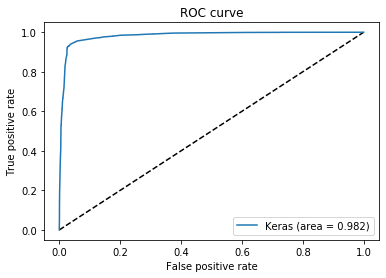

In [3]:
pickle_in = open('X_test_Uni_nstep5.pickle', "rb")
X_test = pickle.load(pickle_in)
pickle_in = open('Y_test_Uni_nstep5.pickle', "rb")
Y_test = pickle.load(pickle_in)

filename = "weights_univariate_nsteps5_thresh7.best.hdf5" #name of model file 

n_steps = 5
n_features = 1

Y_test_arr = np.array(Y_test)
X_test_arr = np.array(X_test)

y_pred_test = load_trained_model_uni(filename, X_test_arr, Y_test_arr, n_steps, n_features)

### Run cell below to plot the wrongly classified features

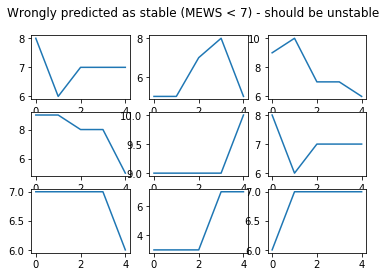

In [120]:
plotting_wrongly_classified(Y_test_arr, X_test_arr, y_pred_test, "stable")

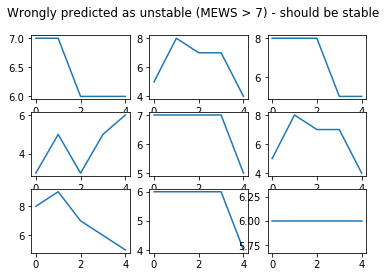

In [121]:
plotting_wrongly_classified(Y_test_arr, X_test_arr, y_pred_test, "unstable")

### Run the cell below to run the ARIMA model on one patient

In [ ]:
#Run this file only if the above and below vectors have not been created before
#Read the data file (it has been converted to a pickle file)
pickle_in = open('full_dataset_anon.pickle', "rb")
data = pickle.load(pickle_in)

#Rename a few columns and convert it to a datetime series
data = data.rename(columns={'substring': 'patient_id'})
data['vital_time'] = data['vital_time'].str.split('+').str[0]
data['vital_time'] = pd.to_datetime(data['vital_time'])

#filter the data that is needed
vitals = data.filter(['patient_id', 'vital_time','pulse','spo2','resp', 'bpSys', 'temperature'], axis = 1)
vitals_full_set = vitals[(vitals != 0).all(1)]

#Creating MEWS column
vitals_full_set = calculate_MEWS(vitals_full_set)

#Removing sensor error
chronic_value = 7 #threshold that you are selecting to define a bad outcome. For example, 7 (MEWS > 7)
vitals_clean = unique_chronic_patient(vitals_full_set, 7)

#Selecting data for one patient_id
df = vitals_clean.loc[vitals_clean['patient_id'] == 'bbbcef620']

Model_ARIMA(df, 2, 2, 2)

### Run the cell below to run the Logistic Regression model on engineered features  

In [ ]:
pickle_in = open('training_data.pickle', "rb")
training_data = pickle.load(pickle_in)

X_train, X_test, y_train, y_test = create_test_train_split(training_data)

fpr, tpr = Model_logRes(X_train, X_test, y_train, y_test, 'lbfgs')

plot_ROC(fpr, tpr)

### Run the cell below to run SVM on engineered features 

In [ ]:
pickle_in = open('training_data.pickle', "rb")
training_data = pickle.load(pickle_in)

X_train, X_test, y_train, y_test = create_test_train_split(training_data)

fpr_SVM, tpr_SVM = Model_SVM(X_train, X_test, y_train, y_test, 'rbf')

plot_ROC(fpr_SVM, tpr_SVM)